# **Aplications to Astrophysics II. Exercise.** C. Soneira



In  dark  matter  simulations,  galaxy  and  cluster  halos were all shown to have mass density profiles well approximated by the NFW (Navarro-French-White) profile:
\begin{equation}
    \rho(r) = \dfrac{\rho_s}{\left(\frac{r}{r_s}\right)\left(1+\frac{r}{r_s}\right)^2}.
\end{equation}

This “universal” profile is still agood approximation to today’s simulated halos. However the higher resolution dark matter simulations reveal subtle differences. Deviations were sought for using a generalized version of the NFW profile. The following are some of those generalized profiles:

\begin{align}
 \textrm{Moore} & \hspace{2cm} \rho(r) = \dfrac{\rho_M}{\left(\frac{r}{r_M}\right)^{\gamma}\left(1+\frac{r}{r_M}\right)^{3-\gamma}},\\
  \textrm{Einasto} & \hspace{2cm} \rho(r) = \rho_E\exp\left(-\dfrac{2}{\alpha}\left(\left(\dfrac{r}{r_M}\right)^{\alpha}-1\right)\right).\\
\end{align}


In this exercise you have to:
   - Read the simulated dark matter halo profile data stored in dark_matter_halo_density_profile.fits
   - Fit the data using the above profile models with **astropy.modeling** and **emcee**
   - Compare the goodness of the fit using the reduced $\chi^2$ and AIC (https://en.wikipedia.org/wiki/Akaike_information_criterion)

## Read the simulated dark matter halo profile data stored in dark_matter_halo_density_profile.fits

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import math

In [2]:
hdul = fits.open('dark_matter_halo_density_profile.fits') 
hdul.info()

Filename: dark_matter_halo_density_profile.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  DM DENSITY PROFILE    1 BinTableHDU     15   50R x 3C   [D, D, D]   


In [3]:
mat = hdul[1].data

In [4]:
R = []
rho = []
u_rho = []

for i in mat:
    R = np.append(R,i[0])
    rho = np.append(rho,i[1])
    u_rho = np.append(u_rho,abs(i[2]))

<ErrorbarContainer object of 3 artists>

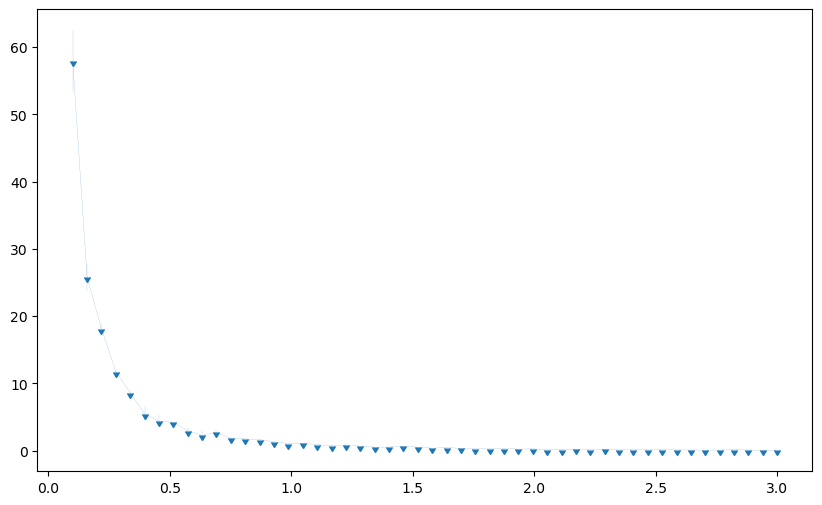

In [5]:
fig,ax = plt.subplots(figsize=(10,6))
ax.errorbar(R,rho,u_rho,linewidth = 0.1, markersize = 5, marker = 11)

## Fit the data using the above profile models with **astropy.modeling** and **emcee**

Model: moore
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          rho_m               r_m               gamma       
    ------------------ ------------------ ------------------
    1.9373064318743425 1.2862851448231234 1.4632780890453918


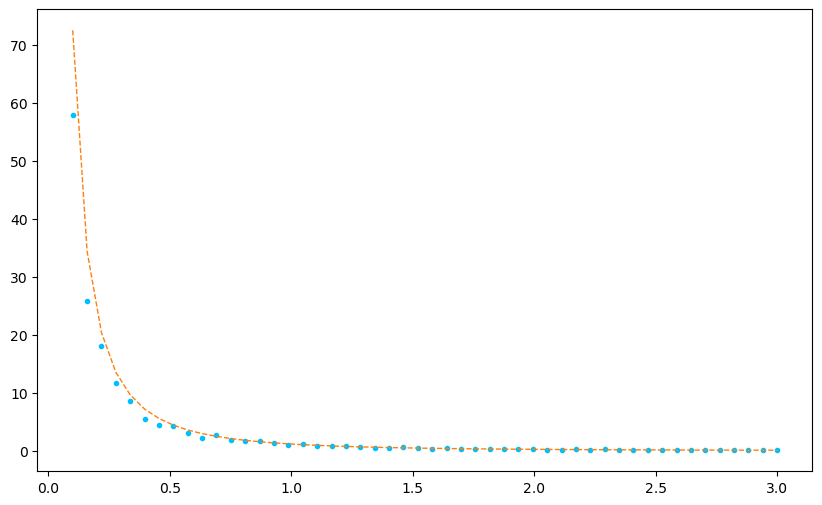

In [6]:
from astropy.modeling import models,fitting
import numpy as np
from astropy.modeling.models import custom_model


# Astropy fitting moore
fitter = fitting.LevMarLSQFitter()

@custom_model
def moore(x, rho_m=1, r_m=2, gamma=2):
    return rho_m/((x/r_m)**gamma*(1+x/r_m)**(3-gamma))

weighted_best_fit = fitter(moore(), R, rho, weights=1/u_rho**2)
print(weighted_best_fit)

astropy_moore = weighted_best_fit(R)

moore_astropy_param = [0,0,0]
moore_astropy_param[0] = weighted_best_fit.rho_m+0
moore_astropy_param[1] = weighted_best_fit.r_m+0
moore_astropy_param[2] = weighted_best_fit.gamma+0

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(R, rho, marker='.', color='deepskyblue',label='data')
ax.plot(R,weighted_best_fit(R), color='C1', linestyle='--', linewidth=1,label='astropy fit')

Model: einasto
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          rho_e               r_m                alpha       
    ------------------ ------------------ -------------------
    0.6056496949111416 1.3337854958316298 0.44219768451264696


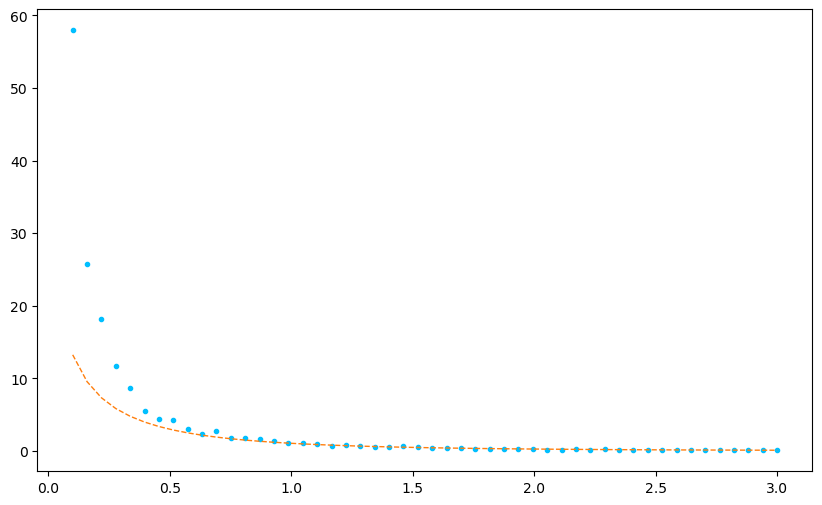

In [7]:
# Astropy fitting einasto
fitter = fitting.LevMarLSQFitter()
e = math.exp(1)
@custom_model
def einasto(x, rho_e=1, r_m=2, alpha=3):
        return rho_e*e**(-2/alpha*((x/r_m)**alpha-1))

weighted_best_fit = fitter(einasto(), R, rho, weights=1/u_rho**2)
print(weighted_best_fit)

astropy_einasto = weighted_best_fit(R)

einasto_astropy_param = [0,0,0]
einasto_astropy_param[0] = weighted_best_fit.rho_e+0
einasto_astropy_param[1] = weighted_best_fit.r_m+0
einasto_astropy_param[2] = weighted_best_fit.alpha+0

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(R, rho, marker='.', color='deepskyblue',label='data')
ax.plot(R,weighted_best_fit(R), color='C1', linestyle='--', linewidth=1,label='astropy fit')

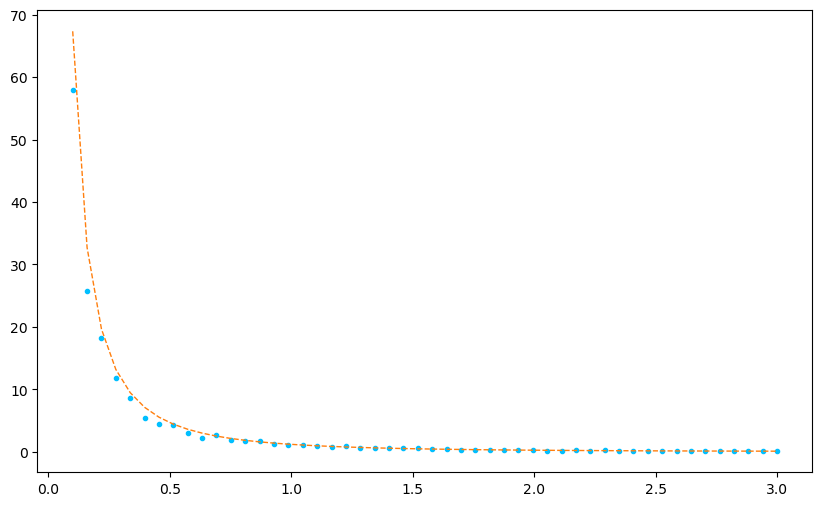

In [14]:
# emcee Moore

import emcee

def model(theta, x):
    #Moore
    rho_m, r_m, gamma = theta
    return rho_m/((x/r_m)**gamma*(1+x/r_m)**(3-gamma))

def log_likelihood(theta, x, y, sigma):
    m = model(theta,x)
    return -0.5 * np.sum((y - m) ** 2 / sigma**2) -  0.5 * x.size * np.log(2 * np.pi) - np.sum(np.log(sigma))

initial_parameters = [1,1,1] 
ndim, nwalkers = len(initial_parameters), 100

pos = [initial_parameters + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(R, rho, u_rho))

Nruns = 500
sampler.run_mcmc(pos, Nruns);

ndiscard = 100
samples = sampler.chain[:,ndiscard:,:].reshape((-1, ndim))
output_emcee = np.mean(samples,axis=0)

moore_emcee_param = output_emcee

emcee_moore = model(output_emcee,R)
L_moore = log_likelihood(output_emcee,R,rho,u_rho)

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(R, rho, marker='.', color='deepskyblue',label='data')
ax.plot(R,model(output_emcee,R), color='C1', linestyle='--', linewidth=1,label='astropy fit')

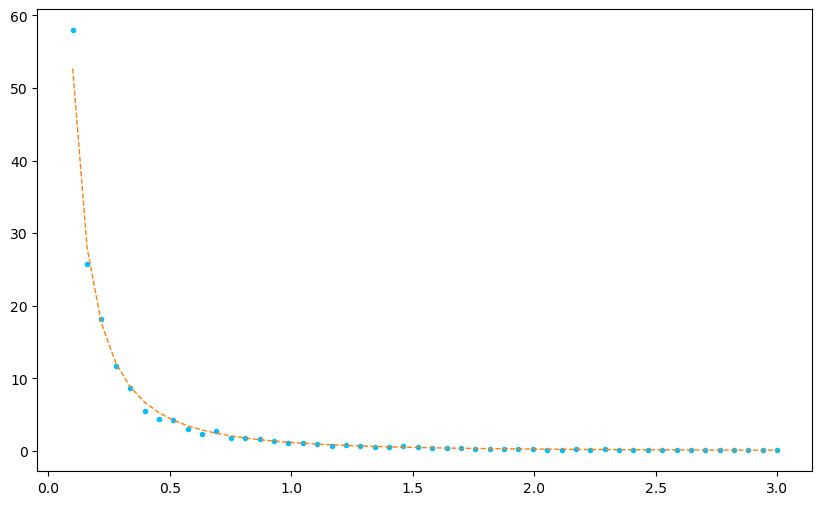

In [16]:
# emcee Einasto

import emcee

def model(theta,x):
    # Einasto
    rho_e, r_m, alpha = theta
    return rho_e*e**(-2/alpha*((x/r_m)**alpha-1))

def log_likelihood(theta, x, y, sigma):
    m = model(theta,x)
    return -0.5 * np.sum((y - m) ** 2 / sigma**2) -  0.5 * x.size * np.log(2 * np.pi) - np.sum(np.log(sigma))

initial_parameters = [1,1,1] 
ndim, nwalkers = len(initial_parameters), 100

pos = [initial_parameters + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(R, rho, u_rho))

Nruns = 500
sampler.run_mcmc(pos, Nruns);

ndiscard = 100
samples = sampler.chain[:,ndiscard:,:].reshape((-1, ndim))
output_emcee = np.mean(samples,axis=0)

einasto_emcee_param = output_emcee

emcee_einasto = model(output_emcee,R)
L_einasto = log_likelihood(output_emcee,R,rho,u_rho)

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(R, rho, marker='.', color='deepskyblue',label='data')
ax.plot(R,model(output_emcee,R), color='C1', linestyle='--', linewidth=1,label='astropy fit')

In [17]:
import pandas as pd

data = {'moore_astropy': moore_astropy_param,  'moore_emcee': moore_emcee_param, 'einasto_astropy': einasto_astropy_param, 'einasto_emcee': einasto_emcee_param}

# Create the table (dataframe)
table = pd.DataFrame(data)

# Print the table
print(table)

   moore_astropy  moore_emcee  einasto_astropy  einasto_emcee
0       1.937306     2.002055         0.605650       1.752202
1       1.286285     1.308119         1.333785       0.815108
2       1.463278     1.412772         0.442198       0.207102


## Compare the goodness of the fit using the reduced $\chi^2$ and AIC (https://en.wikipedia.org/wiki/Akaike_information_criterion)

In [18]:
# chisq
K = len(rho) - 3

# moore
red_chisq_moore = sum((rho-astropy_moore)**2/u_rho**2)/K
print("Reduced chisq for Moore astropy fitting is ",red_chisq_moore)

# einasto
red_chisq_einasto = sum((rho-astropy_einasto)**2/u_rho**2)/K
print("Reduced chisq for Einasto astropy fitting is ",red_chisq_einasto)

# aic AIC = 2K – 2ln(L)
# moore
aic_moore = 2*K -2*L_moore
print("AIC for Moore atropy fitting is ",aic_moore)

# einasto
aic_einasto = 2*K -2*L_einasto
print("AIC for Einasto atropy fitting is ",aic_einasto)

Reduced chisq for Moore astropy fitting is  12.283719226497729
Reduced chisq for Einasto astropy fitting is  413.6918970010481
AIC for Moore atropy fitting is  3554.488641550238
AIC for Einasto atropy fitting is  -62.926456609240915


### So the Einasto fit is not good for none of the methods, but the Moore is reasonably good for the astropy fitting, but not for the emcee fitting.